**นายธนกฤต พิชญาวุธ 62070244**

# **Assignment 2 - Individual Assignment**

## **Part 1: Data Collection**

**Import package Etc.**

In [1]:
import numpy as np
import pandas as pd
import requests
import bs4
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### **1. ระบุหา URLs และ news category labels ทั้งหมด**

In [3]:
#สร้าง List ไว้สำหรับเก็บค่าต่างๆ
list_month = []
link_list = []
list_target = []
list_content = []
list_heading = []

In [4]:
def get_article_data():
  ''' Function นี้ไว้ scrape ข้อมูลตั้งแต่ root URL และ crawl ตาม anchor link ที่ปรากฏ ทำการสกัดข้อมูลส่วนที่เป็น title text กับ body text'''
  #scape ข้อมูลที่เป็น link ในแต่ละเดือนของ root URL 
  response = requests.get('http://www.it.kmitl.ac.th/~teerapong/news_archive/index.html')
  soup = bs4.BeautifulSoup(response.content, 'lxml')
  a_tag=soup.find_all('a')
  for month in a_tag[:12]:
    list_month.append(month['href'])
  #scape ข้อมูลที่เป็น link ในแต่ละ link ของเดือน
  for month in list_month:
    response = requests.get('http://www.it.kmitl.ac.th/~teerapong/news_archive/'+ month)
    soup = bs4.BeautifulSoup(response.content, 'lxml')
    a_tag = soup.find_all('a')
    for link in a_tag[:-4]:
      link_list.append(link['href'])
    targets = soup.find_all('td', class_='category')
    #เก็บข้อมูลในแต่ละ link ที่เป็น category ไว้ใน List
    for target in targets:
      if 'N/A' not in target.text:
          list_target.append(target.text.replace('\xa0', ''))
  #scape ข้อมูลในแต่ละ link เพื่อเก็บข้อมูลที่ต้องการ
  for link in link_list:
    response = requests.get('http://www.it.kmitl.ac.th/~teerapong/news_archive/'+link)
    soup = bs4.BeautifulSoup(response.content, 'lxml')
    #สกัดหาข้อความที่เป็น contents และ heading
    contents = soup.find_all('p', class_=False)
    heading = soup.find('h2')
    #วน loop ทำการนำข้อมูลมาต่อกัน
    only_content = ''
    for content in contents:
      only_content += content.text
    #เพิ่มข้อมูลส่วน heading และ content ไว้ใน List
    list_heading.append(heading.text)
    list_content.append(only_content)
get_article_data()

### **2. ทำการ save เนื้อหาข้อมูล โดยตั้งชื่อไฟล์ให้สื่อความหมายและใช้นามสกุล .txt**

In [5]:
def create_article_file():
  ''' Function นี้ไว้ สร้าง Foler และ ทำการสร้าง File นามสกุล txt จากข้อมูลที่เก็บไว้ใน List'''
  #สร้าง Sub Folder เพื่อที่จะไว้เก็บข้อมูล
  os.makedirs('data/datastore/content/')
  os.makedirs('data/datastore/heading/')
  os.makedirs('data/datastore/heading_plus_content/')
  os.makedirs('data/target/')
  for idx, link in enumerate(link_list):
    #สร้างไฟล์ที่เก็บข้อมูลเฉพาะเนื้อหาของข่าวทั้งหมดไว้ในโฟลเดอร์ content โดยแยกเป็นข่าวละไฟล์
    with open('data/datastore/content/'+ link[:-5] + '.txt', 'w') as write_file:
        write_file.write(list_content[idx])
    write_file.close()
    #สร้างไฟล์ที่เก็บข้อมูลเฉพาะชื่อเรื่องของข่าวทั้งหมดไว้ในโฟลเดอร์ heading โดยแยกเป็นข่าวละไฟล์
    with open('data/datastore/heading/'+ link[:-5] + '.txt', 'w') as write_file:
      write_file.write(list_heading[idx])
    write_file.close()
    #สร้างไฟล์ที่เก็บข้อมูลชื่อเรื่องและเนื้อหาของข่าวทั้งหมดไว้ในโฟลเดอร์ heading plus content โดยแยกเป็นข่าวละไฟล์
    with open('data/datastore/heading_plus_content/'+ link[:-5] + '.txt', 'w') as write_file:
      write_file.write(list_heading[idx])
      write_file.write('\n')
      write_file.write(list_content[idx])
    write_file.close()
  #สร้างไฟล์ที่เก็บข้อมูลของข่าวทั้งหมดเฉพาะแค่ส่วนของเนื้อหาไว้ในไฟล์เดียว
  with open('data/datastore/AllArticles_OnlyContent.txt', 'w') as write_file:
    write_file.writelines('\n'.join(list_content))
  write_file.close()
  #สร้างไฟล์ที่เก็บข้อมูลของข่าวทั้งหมดในส่วนของชื่อเรื่องและเนื้อหาไว้ในไฟล์เดียว
  with open('data/datastore/AllArticles_HeadingPlusContent.txt', 'w') as write_file:
    for idx, link in enumerate(link_list):
      write_file.write(list_heading[idx])
      write_file.write(' ')
      write_file.write(list_content[idx])
      if idx != 1407:
        write_file.write('\n')
  write_file.close()
  #สร้างไฟล์ที่เก็บข้อมูลประเภทของของข่าวทั้งหมดไว้ในไฟล์เดียว
  with open('data/target/category.txt', 'w') as write_file:
      write_file.writelines('\n'.join(list_target))
  write_file.close()
create_article_file()

## **Part 2: Text Classification**

### **1. Load Data**

In [6]:
def load_data():
  '''funcion นี้ ไว้สำหรับโหลดข้อมูลที่ save ไว้ มาสร้างเป็น DataFrame'''
  df_article = pd.read_csv('/content/data/datastore/AllArticles_HeadingPlusContent.txt', sep='\n', header=None, names=['AllArticles_HeadingPlusContent'])
  df_article['AllArticles_OnlyContent'] = pd.read_csv('/content/data/datastore/AllArticles_OnlyContent.txt', sep='\n', header=None)
  df_article['category'] = pd.read_csv('/content/data/target/category.txt', header=None)
  return df_article

In [7]:
df_article = load_data()

In [8]:
df_article

,AllArticles_HeadingPlusContent,AllArticles_OnlyContent,category
0,21st-Century Sports: How Digital Technology Is...,The sporting industry has come a long way sinc...,technology
1,Asian quake hits European shares Asian quake h...,Asian quake hits European sharesShares in Euro...,business
2,BT offers free net phone calls BT is offering ...,BT is offering customers free internet telepho...,technology
3,Barclays shares up on merger talk Barclays sha...,Barclays shares up on merger talkShares in UK ...,business
4,Barkley fit for match in Ireland England centr...,England centre Olly Barkley has been passed fi...,sport
...,...,...,...
1403,Woodward eyes Brennan for Lions Woodward eyes ...,Woodward eyes Brennan for LionsToulouse's form...,sport
1404,WorldCom trial starts in New York The trial of...,"The trial of Bernie Ebbers, former chief execu...",business
1405,Yukos accused of lying to court Yukos accused ...,Yukos accused of lying to courtRussian oil fir...,business
1406,Yukos drops banks from court bid Russian oil c...,Russian oil company Yukos has dropped the thre...,business


### **2. Text Preprocessing**

#### **Tokenising Stopword**

Tokenize คือการตัดคำของประโยค

Stop word คือคำทั่วไปๆที่พบบ่อยในประโยค

Normalize จะทำให้คำนั้นเป็นตัวพิมพ์เล็ก

In [9]:
def tokenising_stopword(txt):
  '''Function นี้ไว้ทำการแบ่งคำ โดยใช้  tokenize จากนั้นจะทำการลบคำที่เป็น stopwords ออกไป และทำการ normalize ให้คำนั้นเป็นตัวพิมพ์เล็ก'''
  tokenize = CountVectorizer().build_tokenizer()
  stopwords = text.ENGLISH_STOP_WORDS
  tokens = tokenize(txt)
  result = [word.lower() for word in tokens if word not in stopwords]
  return result

In [10]:
#เรียกใช้งาน function ของทั้ง 2 Columns
df_article['stopwords_AllArticles_OnlyContent'] = df_article['AllArticles_OnlyContent'].apply(lambda word: tokenising_stopword(word))
df_article['stopwords_AllArticles_HeadingPlusContent'] = df_article['AllArticles_HeadingPlusContent'].apply(lambda word: tokenising_stopword(word))

####**Stemming**

Stemming คือการตัดคำด้วย Heuristic สำหรับคำส่วนใหญ่แต่จะไม่ทุกคำ

In [11]:
def stemming(txt):
  '''Function นี้ไว้ทำการลดฟอร์มของคำให้เป็นกลุ่มๆเดียวกัน โดยใช้กระบวนการของ Stemming และทำการ join ข้อความให้เป็นประโยคเหมือนเดิม'''
  stemmer = PorterStemmer()
  result = ' '.join([stemmer.stem(word) for word in txt])
  return result

In [12]:
df_article['stemming_AllArticles_OnlyContent'] = df_article['stopwords_AllArticles_OnlyContent'].apply(lambda word: stemming(word))
df_article['stemming_AllArticles_HeadingPlusContent'] = df_article['stopwords_AllArticles_HeadingPlusContent'].apply(lambda word: stemming(word))

####**Lemmatization**

Lemmatization คือ กระบวนการในการแปลง Word ด้วยรายการคำศัพท์ใน Dictionary โดยส่วนใหญ่จะตัดในส่วนท้ายของคำ ให้อยู่ในรูปฟอร์มพื้นฐาน

In [13]:
def lemmatizer(txt):
  '''Function นี้ไว้ทำการลดฟอร์มของคำให้เป็นกลุ่มๆเดียวกัน โดยใช้กระบวนการของ Lemmatizer และทำการ join ข้อความให้เป็นประโยคเหมือนเดิม'''
  lemmatizer = WordNetLemmatizer()
  result = ' '.join([lemmatizer.lemmatize(word) for word in txt])
  return result

In [14]:
#เรียกใช้งาน function ของทั้ง 2 Columns
df_article['lemmatizer_AllArticles_OnlyContent'] = df_article['stopwords_AllArticles_OnlyContent'].apply(lambda word: lemmatizer(word))
df_article['lemmatizer_AllArticles_HeadingPlusContent'] = df_article['stopwords_AllArticles_HeadingPlusContent'].apply(lambda word: lemmatizer(word))

####**TF-IDF**

TFIDF (term frequency-inverse document frequency) จะช่วยทำการกรองคำที่มีความ common ออกไป ทำให้รู้ว่าเอกสารแต่ละอันเป็นเรื่องอะไร

In [15]:
def tf_idf(df):
  '''Function ไว้สำหรับแปลงข้อมูลข้อความและถ่วงน้ำหนักคำและตัดคำที่มีค่าน้อยออกไป'''
  vectorizer = TfidfVectorizer(min_df = 5)
  X = vectorizer.fit_transform(df)
  return X

### **3. Multiclass Classification Model**

#### **Hyperparameter optimization**

Hyperparameter optimization คือการหาค่า Parameter ต่างๆที่เหมาะสมในสำหรับแต่ละโมเดลและชุดข้อมูล 

โดยจะใช้ RandomizedSearchCV ในการหาค่า Parameter

In [16]:
X = tf_idf(df_article['stemming_AllArticles_OnlyContent'])
y = df_article['category']

#####**Neural network**

In [17]:
parameters = {'learning_rate_init':[0.01, 0.1, 0.05],
              'momentum':[0.1, 0.3, 0.5, 0.9]
}

model_net = MLPClassifier(solver='adam',
                          activation='logistic'
)

model_net = RandomizedSearchCV(
    model_net, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_net.fit(X, y)

print(f'Best parameters {model_net.best_params_}')
print(f'Mean cross-validated accuracy score of the best_estimator: {model_net.best_score_:.3f}')

Best parameters {'momentum': 0.3, 'learning_rate_init': 0.1}
Mean cross-validated accuracy score of the best_estimator: 0.984


#####**SVM**

In [18]:
parameters = {
    "C": [0.001, 0.01, 0.1, 1.],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
}

model_svc = SVC(
    random_state=42,
    class_weight="balanced",
    probability=True,
)

model_svc = RandomizedSearchCV(
    model_svc, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

model_svc.fit(X, y)

print(f'Best parameters {model_svc.best_params_}')
print(f'Mean cross-validated accuracy score of the best_estimator: {model_svc.best_score_:.3f}')

Best parameters {'kernel': 'linear', 'gamma': 'auto', 'C': 1.0}
Mean cross-validated accuracy score of the best_estimator: 0.985


#####**Logistic Regression**

In [19]:
parameters = {
    "C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    "solver": ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty' : ['l1', 'l2', 'elasticnet']
}

model_logistic_regression = LogisticRegression(
    random_state=42,
    class_weight="balanced"
)

model_logistic_regression = RandomizedSearchCV(
    model_logistic_regression, 
    parameters, 
    cv=5,
    scoring='accuracy', n_jobs=-1
)

model_logistic_regression.fit(X, y)

print(f'Best parameters {model_logistic_regression.best_params_}')
print(f'Mean cross-validated accuracy score of the best_estimator: {model_logistic_regression.best_score_:.3f}')

Best parameters {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.01}
Mean cross-validated accuracy score of the best_estimator: 0.974


#####**KNeighborsClassifier**

In [20]:
parameters = {
    'n_neighbors':[2,3,4,5,6,7,8,9,10],
    'weights':['uniform', 'distance'],
    'leaf_size':[10,20,30,40,50,60,70,80,90,100],
    'p':[1,2]
}

model_KNeighborsClassifier = KNeighborsClassifier()

model_KNeighborsClassifier = RandomizedSearchCV(
    model_KNeighborsClassifier, 
    parameters, 
    cv=5,
    scoring='accuracy', n_jobs=-1
)

model_KNeighborsClassifier.fit(X, y)

print(f'Best parameters {model_KNeighborsClassifier.best_params_}')
print(f'Mean cross-validated accuracy score of the best_estimator: {model_KNeighborsClassifier.best_score_:.3f}')

Best parameters {'weights': 'uniform', 'p': 2, 'n_neighbors': 6, 'leaf_size': 30}
Mean cross-validated accuracy score of the best_estimator: 0.968


####**Apply Model With Hyper Parameter**

เมื่อได้ค่า Parameter ที่เหมาะสมกับโมเดลและชุดข้อมูลแล้ว จะมีวิธีทั้งหมดต่อไปดังนี้



1.   ใช้ข้อมูลที่เป็นส่วนเนื้อหาในการทำ Stemming และ Lemmatisation
2.   ใช้ข้อมูลที่เป็นชื่อเรื่องกับเนื้อหาในการทำ Stemming และ Lemmatisation





ขั้นตอนในการทำมีดังต่อไปนี้


1.   ทำการกำหนดตัวแปร X คิอข้อความที่ใช้ และ Y คือเป้าหมาย
2.   ทำการ Cross Validation หรือการแบ่งข้อมูลที่จะนำไปใช้เทรนโดยมีค่า k=5
3.   ทำการเทรนโมเดลโดยจะใช้ loop ในการทำทั้งหมด 6 โมเดล
2.   ทำการหาค่า Mean ของ Accuracy จากที่แบ่งไว้ 5 ครั้ง 


###### **AllArticles_OnlyContent**

**Stemming**

In [21]:
X = tf_idf(df_article['stemming_AllArticles_OnlyContent'])
y = df_article['category']

In [22]:
X.shape

(1408, 5068)

In [23]:
original_models = {  
     
    "Neural Network": MLPClassifier(solver='adam', activation='logistic', momentum=0.3, learning_rate_init=0.09),
    "Logistic Regression": LogisticRegression(solver='newton-cg', penalty='l2', C=10, random_state=42, class_weight="balanced"),
    "Naive Bayes": MultinomialNB(),
    "Support Vector Machine": SVC(kernel='linear', gamma='scale', C=1.0, random_state=42, class_weight="balanced", probability=True,),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(weights='distance', metric='euclidean')
    
}

for name, model in original_models.items():
  model.fit(X, y)
  print(name + ' trained.')

Neural Network trained.
Logistic Regression trained.
Naive Bayes trained.
Support Vector Machine trained.
Random Forest trained.
K-Nearest Neighbors trained.


In [24]:
acc_scores = {}
original_results = []
for name, model in original_models.items():
  acc_score = cross_val_score(model, X, y, cv=5, scoring="accuracy")
  original_results.append(acc_score.mean())

  model = original_models[name]
  print('------------------ ' + name + ' ------------------')
  print(acc_score)
  print("Mean cross-validation accuracy = %.3f\n" % acc_score.mean())
  acc_scores[name] = acc_score.mean()

------------------ Neural Network ------------------
[0.9822695  0.9929078  0.9822695  0.98220641 0.98220641]
Mean cross-validation accuracy = 0.984

------------------ Logistic Regression ------------------
[0.9822695  0.9964539  0.9822695  0.98220641 0.97508897]
Mean cross-validation accuracy = 0.984

------------------ Naive Bayes ------------------
[0.9893617  0.9929078  0.96453901 0.96797153 0.96797153]
Mean cross-validation accuracy = 0.977

------------------ Support Vector Machine ------------------
[0.9858156  0.9893617  0.9787234  0.98576512 0.98576512]
Mean cross-validation accuracy = 0.985

------------------ Random Forest ------------------
[0.9787234  0.9822695  0.96453901 0.95729537 0.95729537]
Mean cross-validation accuracy = 0.968

------------------ K-Nearest Neighbors ------------------
[0.96808511 0.9751773  0.95744681 0.96797153 0.96441281]
Mean cross-validation accuracy = 0.967



In [25]:
df_score = pd.DataFrame(acc_scores, index=['OnlyContent_Stemming']).T.reset_index().rename(columns={'index': 'Model'})

**Lemmatisation**

In [26]:
X = tf_idf(df_article['lemmatizer_AllArticles_OnlyContent'])
y = df_article['category']

In [27]:
X.shape

(1408, 6227)

In [28]:
original_models = {  
     
    "Neural Network": MLPClassifier(solver='adam', activation='logistic', momentum=0.3, learning_rate_init=0.09),
    "Logistic Regression": LogisticRegression(solver='newton-cg', penalty='l2', C=10, random_state=42, class_weight="balanced"),
    "Naive Bayes": MultinomialNB(),
    "Support Vector Machine": SVC(kernel='linear', gamma='scale', C=1.0, random_state=42, class_weight="balanced", probability=True,),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(weights='distance', metric='euclidean')
    
}

for name, model in original_models.items():
  model.fit(X, y)
  print(name + ' trained.')

Neural Network trained.
Logistic Regression trained.
Naive Bayes trained.
Support Vector Machine trained.
Random Forest trained.
K-Nearest Neighbors trained.


In [29]:
acc_scores = {}
original_results = []
for name, model in original_models.items():
  acc_score = cross_val_score(model, X, y, cv=5, scoring="accuracy")
  original_results.append(acc_score.mean())

  model = original_models[name]
  print('------------------ ' + name + ' ------------------')
  print(acc_score)
  print("Mean cross-validation accuracy = %.3f\n" % acc_score.mean())
  acc_scores[name] = acc_score.mean()

------------------ Neural Network ------------------
[0.9822695  0.9929078  0.9787234  0.98220641 0.97508897]
Mean cross-validation accuracy = 0.982

------------------ Logistic Regression ------------------
[0.9822695  0.9964539  0.9822695  0.98220641 0.97153025]
Mean cross-validation accuracy = 0.983

------------------ Naive Bayes ------------------
[0.9858156  0.9929078  0.96453901 0.96441281 0.97153025]
Mean cross-validation accuracy = 0.976

------------------ Support Vector Machine ------------------
[0.9858156  0.9893617  0.9822695  0.98220641 0.98220641]
Mean cross-validation accuracy = 0.984

------------------ Random Forest ------------------
[0.9787234  0.9822695  0.96453901 0.96441281 0.95729537]
Mean cross-validation accuracy = 0.969

------------------ K-Nearest Neighbors ------------------
[0.95744681 0.96808511 0.95744681 0.97153025 0.95017794]
Mean cross-validation accuracy = 0.961



In [30]:
df_score['OnlyContent_Lemmatizer'] = original_results

###### **AllArticles_HeadingPlusContent**

**Stemming**

In [31]:
X = tf_idf(df_article['stemming_AllArticles_HeadingPlusContent'])
y = df_article['category']

In [32]:
X.shape

(1408, 5083)

In [33]:
original_models = {  
     
    "Neural Network": MLPClassifier(solver='adam', activation='logistic', momentum=0.3, learning_rate_init=0.09),
    "Logistic Regression": LogisticRegression(solver='newton-cg', penalty='l2', C=10, random_state=42, class_weight="balanced"),
    "Naive Bayes": MultinomialNB(),
    "Support Vector Machine": SVC(kernel='linear', gamma='scale', C=1.0, random_state=42, class_weight="balanced", probability=True,),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(weights='distance', metric='euclidean')
    
}

for name, model in original_models.items():
  model.fit(X, y)
  print(name + ' trained.')

Neural Network trained.
Logistic Regression trained.
Naive Bayes trained.
Support Vector Machine trained.
Random Forest trained.
K-Nearest Neighbors trained.


In [34]:
acc_scores = {}
original_results = []
for name, model in original_models.items():
  acc_score = cross_val_score(model, X, y, cv=5, scoring="accuracy")
  original_results.append(acc_score.mean())

  model = original_models[name]
  print('------------------ ' + name + ' ------------------')
  print(acc_score)
  print("Mean cross-validation accuracy = %.3f\n" % acc_score.mean())
  acc_scores[name] = acc_score.mean()

------------------ Neural Network ------------------
[0.9822695  0.9964539  0.9787234  0.97864769 0.97153025]
Mean cross-validation accuracy = 0.982

------------------ Logistic Regression ------------------
[0.9822695  0.9964539  0.9822695  0.98220641 0.97864769]
Mean cross-validation accuracy = 0.984

------------------ Naive Bayes ------------------
[0.9858156  0.9929078  0.96453901 0.97153025 0.97153025]
Mean cross-validation accuracy = 0.977

------------------ Support Vector Machine ------------------
[0.9858156  0.9893617  0.9787234  0.98220641 0.98576512]
Mean cross-validation accuracy = 0.984

------------------ Random Forest ------------------
[0.9822695  0.9751773  0.95744681 0.95373665 0.96085409]
Mean cross-validation accuracy = 0.966

------------------ K-Nearest Neighbors ------------------
[0.96808511 0.9751773  0.94680851 0.97153025 0.96085409]
Mean cross-validation accuracy = 0.964



In [35]:
df_score['HeadingPlusContent_Stemming'] = original_results

**Lemmatisation**

In [36]:
X = tf_idf(df_article['lemmatizer_AllArticles_HeadingPlusContent'])
y = df_article['category']

In [37]:
X.shape

(1408, 6254)

In [38]:
original_models = {  
     
    "Neural Network": MLPClassifier(solver='adam', activation='logistic', momentum=0.3, learning_rate_init=0.09),
    "Logistic Regression": LogisticRegression(solver='newton-cg', penalty='l2', C=10, random_state=42, class_weight="balanced"),
    "Naive Bayes": MultinomialNB(),
    "Support Vector Machine": SVC(kernel='linear', gamma='scale', C=1.0, random_state=42, class_weight="balanced", probability=True,),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(weights='distance', metric='euclidean')
    
}

for name, model in original_models.items():
  model.fit(X, y)
  print(name + ' trained.')

Neural Network trained.
Logistic Regression trained.
Naive Bayes trained.
Support Vector Machine trained.
Random Forest trained.
K-Nearest Neighbors trained.


In [39]:
acc_scores = {}
original_results = []
for name, model in original_models.items():
  acc_score = cross_val_score(model, X, y, cv=5, scoring="accuracy")
  original_results.append(acc_score.mean())

  model = original_models[name]
  print('------------------ ' + name + ' ------------------')
  print(acc_score)
  print("Mean cross-validation accuracy = %.3f\n" % acc_score.mean())
  acc_scores[name] = acc_score.mean()

------------------ Neural Network ------------------
[0.9787234  0.9929078  0.9822695  0.97864769 0.97508897]
Mean cross-validation accuracy = 0.982

------------------ Logistic Regression ------------------
[0.9822695  0.9964539  0.9822695  0.98220641 0.97508897]
Mean cross-validation accuracy = 0.984

------------------ Naive Bayes ------------------
[0.9893617  0.9929078  0.96453901 0.98220641 0.97153025]
Mean cross-validation accuracy = 0.980

------------------ Support Vector Machine ------------------
[0.9858156  0.9893617  0.9787234  0.98220641 0.98220641]
Mean cross-validation accuracy = 0.984

------------------ Random Forest ------------------
[0.9787234  0.9787234  0.95390071 0.96441281 0.96085409]
Mean cross-validation accuracy = 0.967

------------------ K-Nearest Neighbors ------------------
[0.96099291 0.97163121 0.95390071 0.97153025 0.94661922]
Mean cross-validation accuracy = 0.961



In [40]:
df_score['HeadingPlusContent_Lemmatizer'] = original_results

####**Best models for text classification**

โมเดลที่นำมาใช้มีทั้งหมด 6 โมเดล และเหตุผลที่นำมาใช้ ดังนี้

*   **Support Vector Machine** เป็น Algorithum ของ Machine Learning ที่ใช้ในการจัดหมวดหมู่ข้อความได้มีประสิทธิภาพ โดยอาศัยหลักการของการหาสัมประสิทธิ์ของสมการเพื่อสร้างเส้นแบ่งแยกกลุ่มข้อมูลที่ถูกป้อนเข้าสู่กระบวนการสอนให้ระบบเรียนรู้ โดยเน้นไปยังเส้นแบ่งแยกแยะกลุ่มข้อมูลได้ดีที่สุด
*   **Logistic Regression** เป็นการวิเคราะห์ที่มีเป้าหมายเพื่อทำนายโอกาสที่จะเกิด
เหตุการณ์ที่สนใจ โดยอาศัยสมการโลจิสติคที่สร้างขึ้นจากชุดตัวแปรทำนาย โดยโมเดลนี้มีการประมวลค่อนข้างเร็วและมึความแม่นคำ
*   **Neural Network**	เป็น Algorithum ที่มีเทคนิคจากการทำงานของสมองของมนุษย์ที่ใช้ในการตัดสินใจซึ่งเรียกว่าโครงข่ายประสาทเทียมซึ่ง Deep learing นั้นมีประโยชน์มากในการจำแนกประเภทของข้อความและทำให้มีความแม่นยำสูง 

*   **Naive Bayes**	ซึ่งเป็น Algorithum ที่มีการใช้มากที่สุดในการจัดประเภทและวิเคราะห์ข้อความ  โดยใช้ Multinomial(MNB) ซึ่งจะได้ประสิทธิภาพดีที่สุด โดยทฤษฎีบทของ Bayes จะคำนวณแบบมีเงื่อนไขของการเกิดขึ้นทั้งสองเหตุการณ์  โดยพิจารณาจากความน่าจะเป็น

*   **Random Forest**	เป็นหนึ่งในกลุ่มของโมเดลที่เรียกว่า Ensemble learning โดยถูกพัฒนาจาก Dicision Tree ซึ่งทำให้ประสิทธิภาพการทำงานสูงขึ้น
*   **K-Nearest Neighbors** คือการจัดแบ่งคลาส โดยจะตัดสินใจว่า คลาสใดที่จะแทนเงื่อนไขหรือกรณีใหม่ๆ ได้บ้าง โดยการตรวจสอบจำนวนบางจำนวน ในขั้นตอนวิธีการเพื่อนบ้านใกล้ที่สุด ของกรณีหรือเงื่อนไขที่เหมือนกันหรือใกล้เคียงกันมากที่สุด โดยจะหาผลรวม (Count Up) ของจำนวนเงื่อนไข หรือกรณีต่างๆ สำหรับแต่ละคลาส และกำหนดเงื่อนไขใหม่ๆ ให้คลาสที่เหมือนกันกับคลาสที่ใกล้เคียงกันมากที่สุด

######**OnlyContent with Stemming**

ชุดข้อมูลที่เก็บเฉพาะข้อความในส่วน body และเลือกการใช้การตัดคำแบบ Stemming นั้น ค่า Accuracy โมเดล Support Vector Machine มีค่ามากที่สุด

In [70]:
df_score[['Model', 'OnlyContent_Stemming']].sort_values(by='OnlyContent_Stemming', ascending=False)

,Model,OnlyContent_Stemming
3,Support Vector Machine,0.985086
0,Neural Network,0.984372
1,Logistic Regression,0.983658
2,Naive Bayes,0.976550
4,Random Forest,0.968025
5,K-Nearest Neighbors,0.966619


Text(0.5, 1.0, 'OnlyContent with Stemming')

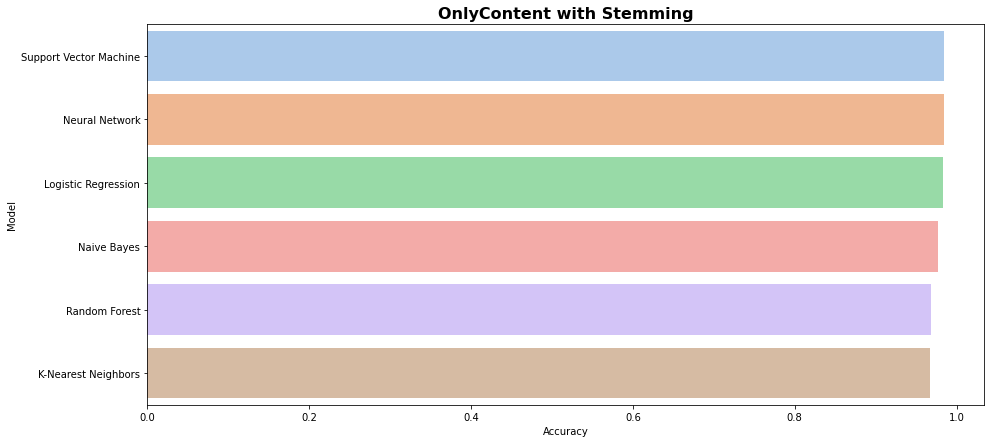

In [71]:
score_sort = df_score.sort_values(by='OnlyContent_Stemming', ascending=False)

plt.figure(figsize= (15,7))
p = sns.barplot(x = score_sort['OnlyContent_Stemming'],y = score_sort['Model'],palette='pastel')
plt.xlabel("Accuracy")
plt.title("OnlyContent with Stemming", fontsize=16, fontweight="bold")

######**OnlyContent with Lemmatisation**

ชุดข้อมูลที่เก็บเฉพาะข้อความในส่วน body และเลือกการใช้การตัดคำแบบ Lemmatisation นั้น ค่า Accuracy โมเดล Support Vector Machine มีค่ามากที่สุด

In [72]:
df_score[['Model', 'OnlyContent_Lemmatizer']].sort_values(by='OnlyContent_Lemmatizer', ascending=False)

,Model,OnlyContent_Lemmatizer
3,Support Vector Machine,0.984372
1,Logistic Regression,0.982946
0,Neural Network,0.982239
2,Naive Bayes,0.975841
4,Random Forest,0.969448
5,K-Nearest Neighbors,0.960937


Text(0.5, 1.0, 'OnlyContent with Lemmatisation')

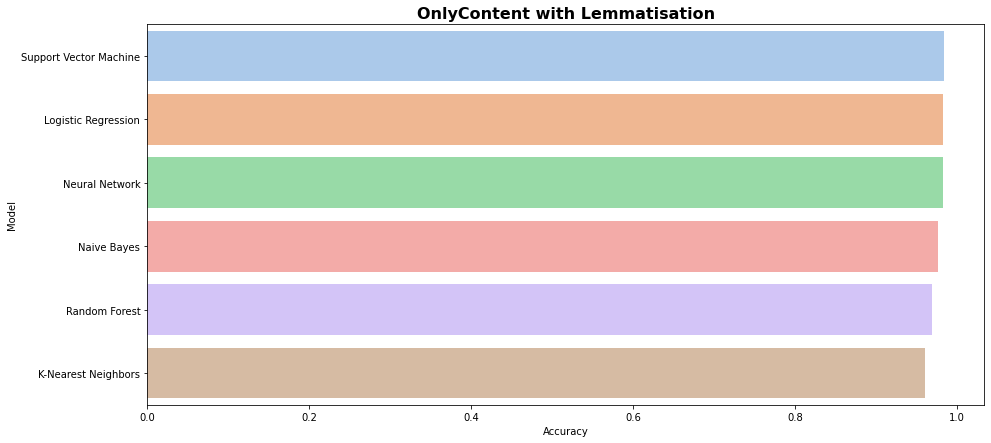

In [73]:
score_sort = df_score.sort_values(by='OnlyContent_Lemmatizer', ascending=False)

plt.figure(figsize= (15,7))
sns.barplot(x = score_sort['OnlyContent_Lemmatizer'],y = score_sort['Model'],palette='pastel')
plt.xlabel("Accuracy")
plt.title("OnlyContent with Lemmatisation", fontsize=16, fontweight="bold")

######**HeadingPlusContent with Stemming**

ชุดข้อมูลที่เก็บข้อความในส่วน title กับ body  และเลือกการใช้การตัดคำแบบ Stemming นั้น ค่า Accuracy โมเดล Support Vector Machine มีค่ามากที่สุด

In [74]:
df_score[['Model', 'HeadingPlusContent_Stemming']].sort_values(by='HeadingPlusContent_Stemming', ascending=False)

,Model,HeadingPlusContent_Stemming
3,Support Vector Machine,0.984374
1,Logistic Regression,0.984369
0,Neural Network,0.981525
2,Naive Bayes,0.977265
4,Random Forest,0.965897
5,K-Nearest Neighbors,0.964491


Text(0.5, 1.0, 'HeadingPlusContent with Stemming')

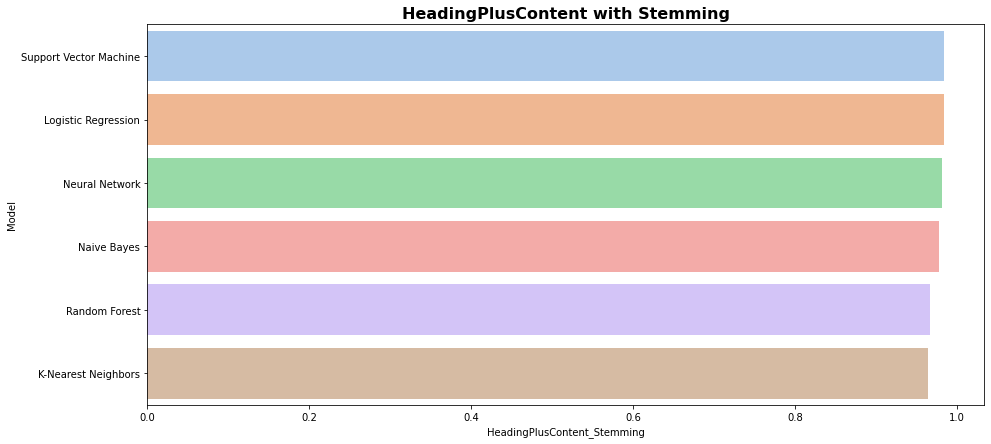

In [75]:
score_sort = df_score.sort_values(by='HeadingPlusContent_Stemming', ascending=False)

plt.figure(figsize= (15,7))
sns.barplot(x = score_sort['HeadingPlusContent_Stemming'],y = score_sort['Model'],palette='pastel')
plt.title("HeadingPlusContent with Stemming", fontsize=16, fontweight="bold")

######**HeadingPlusContent with Lemmatisation**

ชุดข้อมูลที่เก็บข้อความในส่วน title กับ body  และเลือกการใช้การตัดคำแบบ Lemmatisation นั้น ค่า Accuracy โมเดล Support Vector Machine มีค่ามากที่สุด

In [76]:
df_score[['Model', 'HeadingPlusContent_Lemmatizer']].sort_values(by='HeadingPlusContent_Lemmatizer', ascending=False)

,Model,HeadingPlusContent_Lemmatizer
3,Support Vector Machine,0.983663
1,Logistic Regression,0.983658
0,Neural Network,0.981527
2,Naive Bayes,0.980109
4,Random Forest,0.967323
5,K-Nearest Neighbors,0.960935


Text(0.5, 1.0, 'HeadingPlusContent with Lemmatisation')

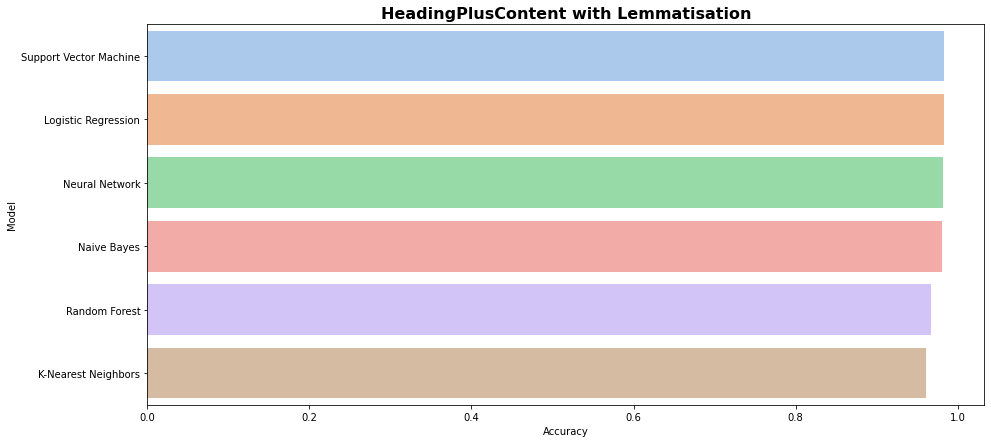

In [77]:
score_sort = df_score.sort_values(by='HeadingPlusContent_Lemmatizer', ascending=False)

plt.figure(figsize= (15,7))
sns.barplot(x = score_sort['HeadingPlusContent_Lemmatizer'],y = score_sort['Model'],palette='pastel')
plt.xlabel("Accuracy")
plt.title("HeadingPlusContent with Lemmatisation", fontsize=16, fontweight="bold")

######**Stemming vs Lemmatisation with OnlyPlusContent**

การเปรียบระหว่างการตัดคำแบบ Stemming กับ Lemmatisation 

ค่า Accuracy  โดยรวมในแบบ Stemming สูงกว่าแต่ก็มีบางโมเดลที่ Lemmatisation สูงกว่า

In [78]:
df_score_select = df_score[['Model', 'OnlyContent_Stemming', 'OnlyContent_Lemmatizer']]
df_score_reshape = pd.melt(df_score_select, id_vars="Model", var_name="type", value_name="Accuracy").sort_values(by='Accuracy', ascending=False)

df_score_reshape

,Model,type,Accuracy
3,Support Vector Machine,OnlyContent_Stemming,0.985086
0,Neural Network,OnlyContent_Stemming,0.984372
9,Support Vector Machine,OnlyContent_Lemmatizer,0.984372
1,Logistic Regression,OnlyContent_Stemming,0.983658
7,Logistic Regression,OnlyContent_Lemmatizer,0.982946
6,Neural Network,OnlyContent_Lemmatizer,0.982239
2,Naive Bayes,OnlyContent_Stemming,0.976550
8,Naive Bayes,OnlyContent_Lemmatizer,0.975841
10,Random Forest,OnlyContent_Lemmatizer,0.969448
4,Random Forest,OnlyContent_Stemming,0.968025


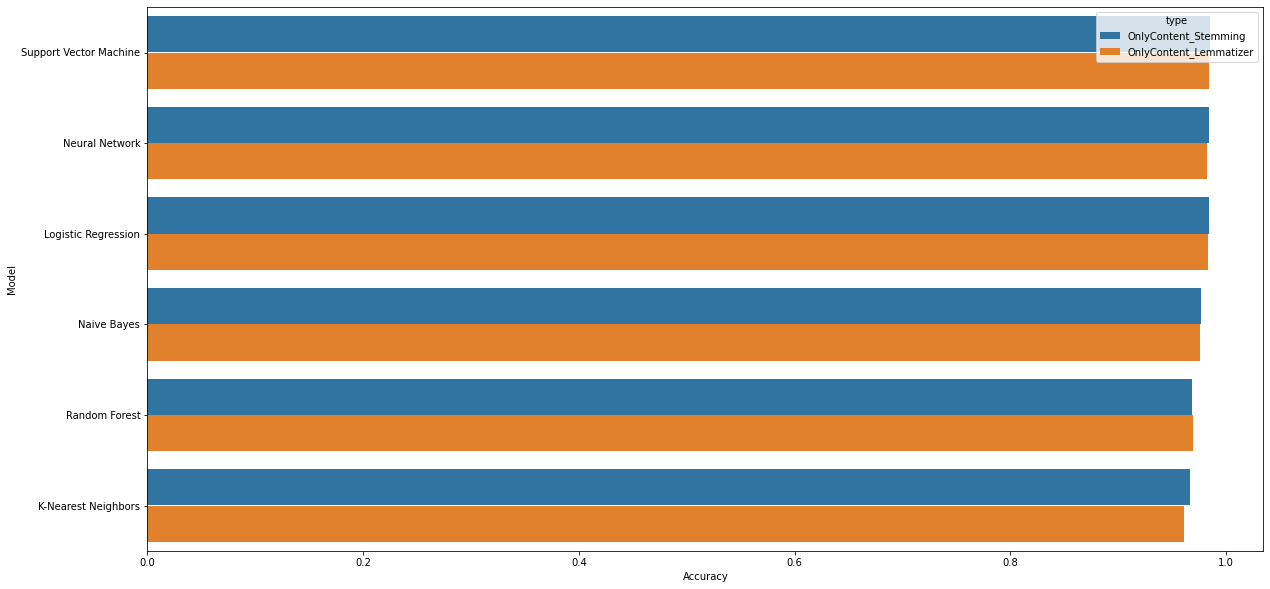

In [79]:
plt.figure(figsize= (20,10))
sns.barplot(data = df_score_reshape,x = 'Accuracy',y = 'Model',hue = 'type')

######**Stemming vs Lemmatizer with HeadingPlusContent**

การเปรียบระหว่างการตัดคำแบบ Stemming กับ Lemmatisation 

ค่า Accuracy  โดยรวมในแบบ Stemming สูงกว่าแต่ก็มีบางโมเดลที่ Lemmatisation สูงกว่า

In [80]:
df_score_select = df_score[['Model', 'HeadingPlusContent_Stemming', 'HeadingPlusContent_Lemmatizer']]
df_score_reshape = pd.melt(df_score_select, id_vars="Model", var_name="type", value_name="Accuracy").sort_values(by='Accuracy', ascending=False)

df_score_reshape

,Model,type,Accuracy
3,Support Vector Machine,HeadingPlusContent_Stemming,0.984374
1,Logistic Regression,HeadingPlusContent_Stemming,0.984369
9,Support Vector Machine,HeadingPlusContent_Lemmatizer,0.983663
7,Logistic Regression,HeadingPlusContent_Lemmatizer,0.983658
6,Neural Network,HeadingPlusContent_Lemmatizer,0.981527
0,Neural Network,HeadingPlusContent_Stemming,0.981525
8,Naive Bayes,HeadingPlusContent_Lemmatizer,0.980109
2,Naive Bayes,HeadingPlusContent_Stemming,0.977265
10,Random Forest,HeadingPlusContent_Lemmatizer,0.967323
4,Random Forest,HeadingPlusContent_Stemming,0.965897


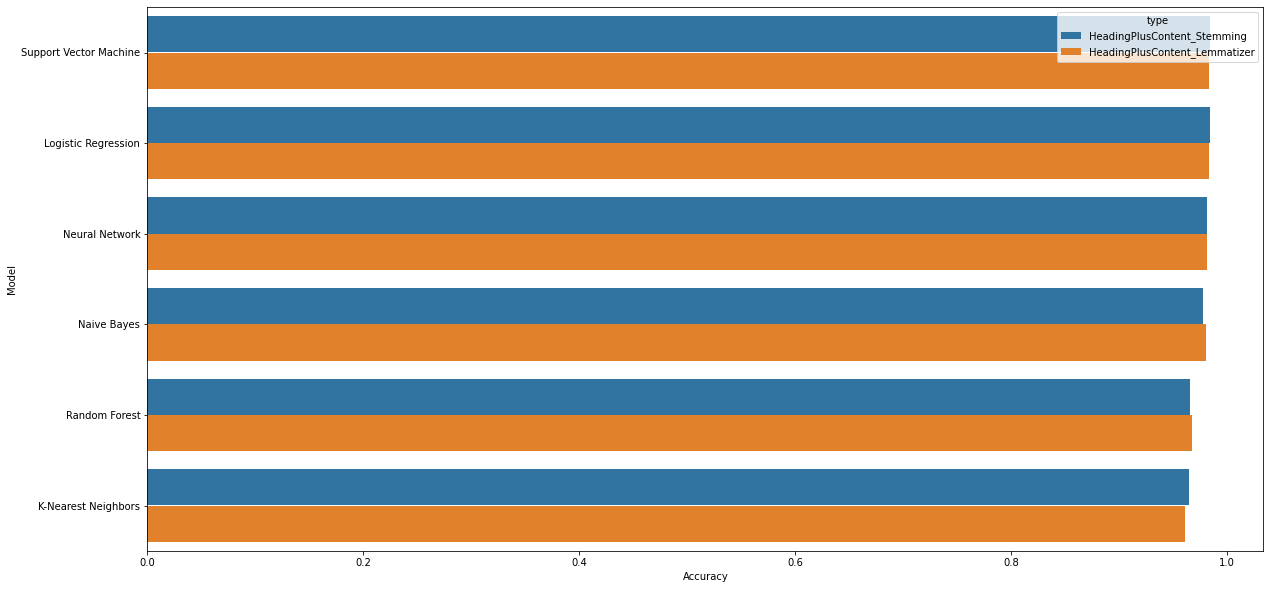

In [81]:
plt.figure(figsize= (20,10))
sns.barplot(data = df_score_reshape,x = 'Accuracy',y = 'Model',hue = 'type')

####**Summary**

Support Vector Machine เป็นโมเดลที่มีค่า Accuracy สูงที่สุด

การตัดคำแบบ Stemming มีค่า Accuracy สูงกว่าแบบ Lemmatisation

การใช้ข้อมูลเฉพาะส่วนของเนื้อหามีค่า Accuracy สูงกว่าแบบชื่อเรื่องกับเนื้อหา

In [82]:
df_score_reshape = pd.melt(df_score, id_vars="Model", var_name="type", value_name="Accuracy").sort_values(by='Accuracy', ascending=False)
df_score_reshape

,Model,type,Accuracy
3,Support Vector Machine,OnlyContent_Stemming,0.985086
15,Support Vector Machine,HeadingPlusContent_Stemming,0.984374
0,Neural Network,OnlyContent_Stemming,0.984372
9,Support Vector Machine,OnlyContent_Lemmatizer,0.984372
13,Logistic Regression,HeadingPlusContent_Stemming,0.984369
21,Support Vector Machine,HeadingPlusContent_Lemmatizer,0.983663
1,Logistic Regression,OnlyContent_Stemming,0.983658
19,Logistic Regression,HeadingPlusContent_Lemmatizer,0.983658
7,Logistic Regression,OnlyContent_Lemmatizer,0.982946
6,Neural Network,OnlyContent_Lemmatizer,0.982239


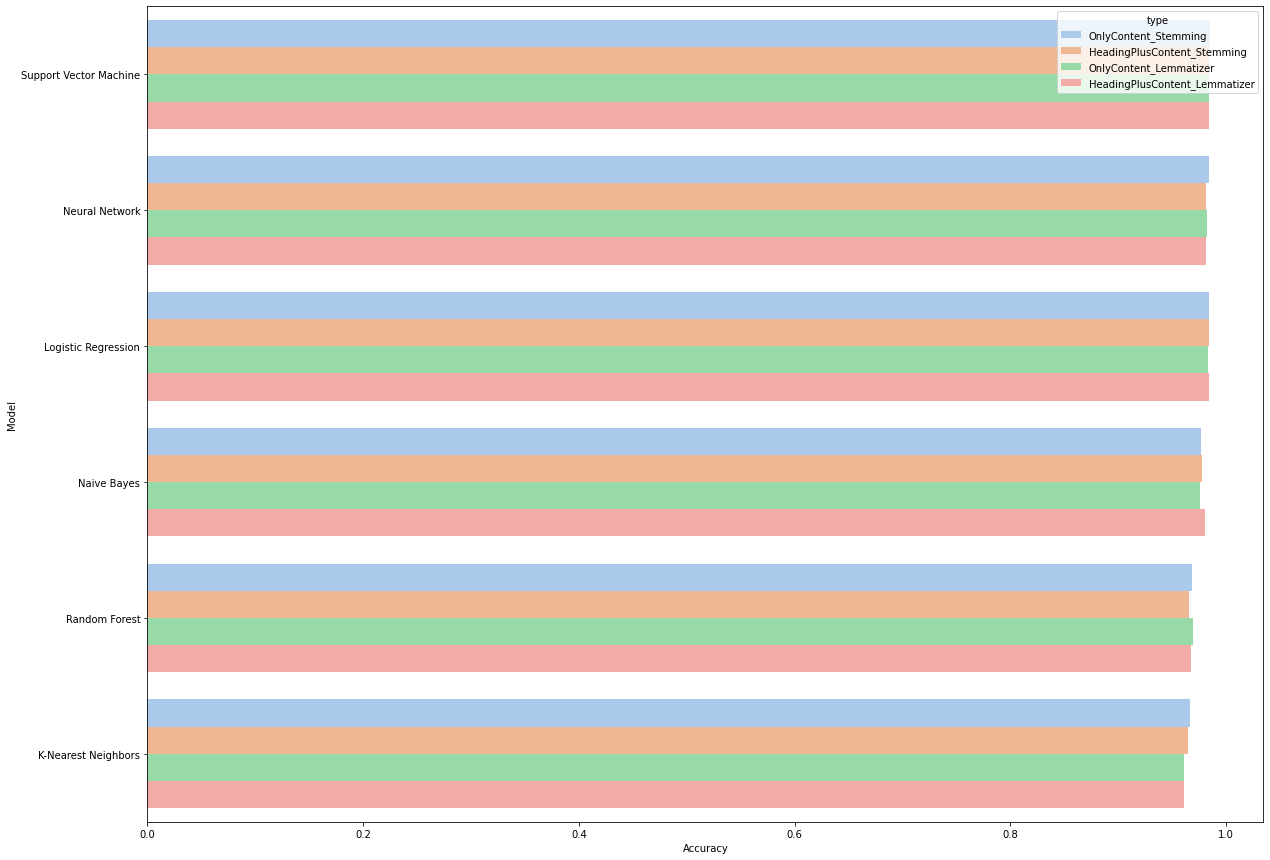

In [83]:
plt.figure(figsize= (20,15))
sns.barplot(data = df_score_reshape,x = 'Accuracy',y = 'Model',hue = 'type', palette='pastel')